In [1]:
!pip install catboost
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from tqdm.notebook import trange, tqdm
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.api import datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.9 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()

Saving data_for_analysis.zip to data_for_analysis.zip


{'data_for_analysis.zip': b'PK\x03\x04\x14\x00\x00\x00\x00\x00\xc4\x9bsV\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1a\x00\x00\x00data_for_analysis/dataset/PK\x03\x04\x14\x00\x00\x00\x00\x00\xc4\x9bsV\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1f\x00\x00\x00data_for_analysis/dataset/loc1/PK\x03\x04\x14\x00\x00\x00\x08\x00\xc4\x9bsV=\x93\xe5\x94nF\x00\x00R\xde\x00\x00,\x00\x00\x00data_for_analysis/dataset/loc1/loc1_data.csv\xe5}[\xb2%Ar\xd4\xff\xac\x82\x05\\\xeb\xa9|g\xf6:\xd8\x80\xcc\x183\xf41H\x06\xc3\xfeq\xf7\xc8\xaa\x8c8\xf7\x9cV7B\xf0\xc1\x08\x8d\x8c\xbe\x19\xa7\xf2\x15\x1e\xef\xc8\x7f\xfc\xf3\xdf\xff\xf6?\xfe\xf1O\x7f\xff\xd7\xaf\x7f\xfc\xed\xef\xff\xfa\xb7\xff\xfeO\xff\xf8\x9f\xff\xfdo_\xff\xfa_\xbf\xfe\xcb\xbf|\xfd\xd3\xdf\xff\xfe/\xff\xed\x9f\xff\xe9\xeb_\xfe\xe7?\xfe\xc7?\xff\x97\xbf\xfd\xe73\xe0/9\xff\xb5\xfd5_i\xfc\xa74~\x96\xeb\xab\\?\xf2\xf8*?F\xf9\xba~\xf4\x84\xff\xba\xf8\x9fZV\x9ac\xcet\xa5+\xb7\xfa\xf5\x97r=t\xf5g\x1a_5\xfdh_\xf8\x8f\xffC\xff\x89\xdf\xeb?z\x

In [3]:
!unzip data_for_analysis.zip

Archive:  data_for_analysis.zip
   creating: data_for_analysis/dataset/
   creating: data_for_analysis/dataset/loc1/
  inflating: data_for_analysis/dataset/loc1/loc1_data.csv  
  inflating: data_for_analysis/dataset/loc1/loc1_weather.json  
   creating: data_for_analysis/dataset/loc2/
  inflating: data_for_analysis/dataset/loc2/loc2_data.csv  
  inflating: data_for_analysis/dataset/loc2/loc2_weather.json  
   creating: data_for_analysis/dataset/loc3/
  inflating: data_for_analysis/dataset/loc3/loc3_data.csv  
  inflating: data_for_analysis/dataset/loc3/loc3_weather.json  
   creating: data_for_analysis/dataset/loc4/
  inflating: data_for_analysis/dataset/loc4/loc4_data.csv  
  inflating: data_for_analysis/dataset/loc4/loc4_weather.json  
   creating: data_for_analysis/dataset/loc5/
  inflating: data_for_analysis/dataset/loc5/loc5_weather.json  


In [671]:
def data_prepair(csv_file, JSON_file):
    data_dict = pd.concat([JSON_file['data'].apply(pd.Series)])
    cloudsDF = pd.concat([data_dict['clouds'].apply(pd.Series)])
    cloudsDF = cloudsDF.rename(columns={'all': "clouds"}).drop(0, axis=1)

    windDF = pd.concat([data_dict['wind'].apply(pd.Series)])
    windDF = windDF.rename(columns={'speed': "wind_speed", 'deg' : 'wind_deg'}).drop(0, axis=1)

    data_dict = pd.concat([data_dict.drop(columns=['clouds', 'wind']), cloudsDF, windDF], axis=1)

    JSON_file = pd.concat([JSON_file.drop(columns=['data']), data_dict], axis=1)

    JSON_file['generatedAt'] = pd.to_datetime(JSON_file['generatedAt']).dt.tz_localize(None).dt.floor('h')
    JSON_file = JSON_file.drop(columns=['created', 'lastUpdated'])
    JSON_file = JSON_file.rename(columns={'generatedAt': "timestamp"})

    csv_file.timestamp = pd.to_datetime(csv_file['timestamp']).dt.floor('h')
    JSON_file = JSON_file.groupby(pd.Grouper(key="timestamp", freq="d")).mean()
    csv_file = csv_file.groupby(pd.Grouper(key="timestamp", freq="d")).mean()
    return JSON_file.merge(csv_file, on='timestamp')

In [672]:
data1 = data_prepair(pd.read_csv('data_for_analysis/dataset/loc1/loc1_data.csv'), pd.read_json('data_for_analysis/dataset/loc1/loc1_weather.json'))
data2 = data_prepair(pd.read_csv('data_for_analysis/dataset/loc2/loc2_data.csv'), pd.read_json('data_for_analysis/dataset/loc2/loc2_weather.json'))
data3 = data_prepair(pd.read_csv('data_for_analysis/dataset/loc3/loc3_data.csv'), pd.read_json('data_for_analysis/dataset/loc3/loc3_weather.json'))
data = pd.concat([data1, data2, data3]).sort_values(by=['timestamp'])
data

,migration,temperature_x,temperature_min,temperature_max,pressure,humidity,sea_level,clouds,wind_speed,wind_deg,temperature_y,ph,do,ammonia,outsideTemperature,gust
timestamp,,,,,,,,,,,,,,,,
2017-03-28,1.0,301.372000,301.372000,301.372000,1026.77000,98.000,NaN,NaN,NaN,NaN,27.585000,2.130000,6.635000,9.014117e-08,NaN,NaN
2017-03-29,1.0,301.840000,301.840000,301.840000,1025.43000,96.000,NaN,NaN,NaN,NaN,34.057500,7.787500,7.681250,1.262822e-01,NaN,NaN
2017-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.844667,8.448000,8.594667,2.162955e-01,NaN,NaN
2017-03-31,1.0,302.188000,302.188000,302.188000,1026.65000,94.000,NaN,NaN,NaN,NaN,31.046667,8.359167,5.201667,1.656662e-01,NaN,NaN
2017-04-01,1.0,302.214000,302.214000,302.214000,1025.18000,94.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-15,NaN,298.014000,298.014000,298.014000,1014.46000,72.750,1026.060000,24.0,1.64000,153.190663,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-16,NaN,296.914125,296.914125,296.914125,1014.42875,77.250,1025.803333,11.0,1.67875,198.877763,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-17,NaN,296.508250,296.508250,296.508250,1014.15750,71.625,1026.405000,12.5,2.03750,86.504162,NaN,NaN,NaN,NaN,NaN,NaN


In [673]:
data.isnull().sum().sort_values(ascending=False)

outsideTemperature    749
gust                  749
sea_level             720
clouds                720
wind_speed            720
wind_deg              720
ph                    584
ammonia               584
do                    582
temperature_y         542
migration              50
temperature_x          22
temperature_min        22
temperature_max        22
pressure               22
humidity               22
dtype: int64

In [674]:
#delite because 100% in NaN
data = data.drop(columns=['sea_level', 'wind_deg', 'wind_speed', 'clouds', 'outsideTemperature', 'gust', ])
#replase with median 
data.fillna(data.median(), inplace=True)
data = data.dropna()
data.reset_index(inplace=True)

In [675]:
data

,timestamp,migration,temperature_x,temperature_min,temperature_max,pressure,humidity,temperature_y,ph,do,ammonia
0,2017-03-28,1.0,301.372000,301.372000,301.372000,1026.77000,98.000,27.585000,2.130000,6.635000,9.014117e-08
1,2017-03-29,1.0,301.840000,301.840000,301.840000,1025.43000,96.000,34.057500,7.787500,7.681250,1.262822e-01
2,2017-03-30,1.0,301.648000,301.646625,301.655375,1013.34375,85.000,32.844667,8.448000,8.594667,2.162955e-01
3,2017-03-31,1.0,302.188000,302.188000,302.188000,1026.65000,94.000,31.046667,8.359167,5.201667,1.656662e-01
4,2017-04-01,1.0,302.214000,302.214000,302.214000,1025.18000,94.000,31.413333,8.573750,5.125000,2.799376e-01
...,...,...,...,...,...,...,...,...,...,...,...
744,2018-01-15,1.0,298.014000,298.014000,298.014000,1014.46000,72.750,31.413333,8.573750,5.125000,2.799376e-01
745,2018-01-16,1.0,296.914125,296.914125,296.914125,1014.42875,77.250,31.413333,8.573750,5.125000,2.799376e-01
746,2018-01-17,1.0,296.508250,296.508250,296.508250,1014.15750,71.625,31.413333,8.573750,5.125000,2.799376e-01
747,2018-01-18,1.0,296.266125,296.266125,296.266125,1014.50625,73.875,26.370000,5.910000,1.440000,5.073192e-04


In [676]:
df1 = data.melt(id_vars=['timestamp'], var_name = 'val').query("val in ['temperature_max', 'temperature_min']")
px.line(df1, x='timestamp', y='value', color='val' ).show()

In [677]:
#drop temperature_min and temperature_max
data = data.drop(columns=['temperature_max', 'temperature_min'])

In [678]:
# drop column because only 1
display(data.migration.value_counts())
data = data.drop(columns=['migration'])

1.0    749
Name: migration, dtype: int64

In [679]:
df1 = data.melt(id_vars=['timestamp'], var_name = 'val').query("val in ['temperature_x', 'temperature_y']")
px.line(df1, x='timestamp', y='value', color='val' ).show()

In [680]:
fig = px.line(data, x='timestamp', y="humidity", title='temp')
fig.show()

In [681]:

data

,timestamp,temperature_x,pressure,humidity,temperature_y,ph,do,ammonia
0,2017-03-28,301.372000,1026.77000,98.000,27.585000,2.130000,6.635000,9.014117e-08
1,2017-03-29,301.840000,1025.43000,96.000,34.057500,7.787500,7.681250,1.262822e-01
2,2017-03-30,301.648000,1013.34375,85.000,32.844667,8.448000,8.594667,2.162955e-01
3,2017-03-31,302.188000,1026.65000,94.000,31.046667,8.359167,5.201667,1.656662e-01
4,2017-04-01,302.214000,1025.18000,94.000,31.413333,8.573750,5.125000,2.799376e-01
...,...,...,...,...,...,...,...,...
744,2018-01-15,298.014000,1014.46000,72.750,31.413333,8.573750,5.125000,2.799376e-01
745,2018-01-16,296.914125,1014.42875,77.250,31.413333,8.573750,5.125000,2.799376e-01
746,2018-01-17,296.508250,1014.15750,71.625,31.413333,8.573750,5.125000,2.799376e-01
747,2018-01-18,296.266125,1014.50625,73.875,26.370000,5.910000,1.440000,5.073192e-04


In [682]:
fig = px.line(data, x='timestamp', y="ammonia", title='temp')
fig.show()


In [683]:
fig = px.box(data, y="temperature_x", title='y1 + y2')
fig.show()

In [684]:
data = data.query('temperature_x < 307 or temperature_x > 296.5')

<ipython-input-685-008cd913e27d>:3: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



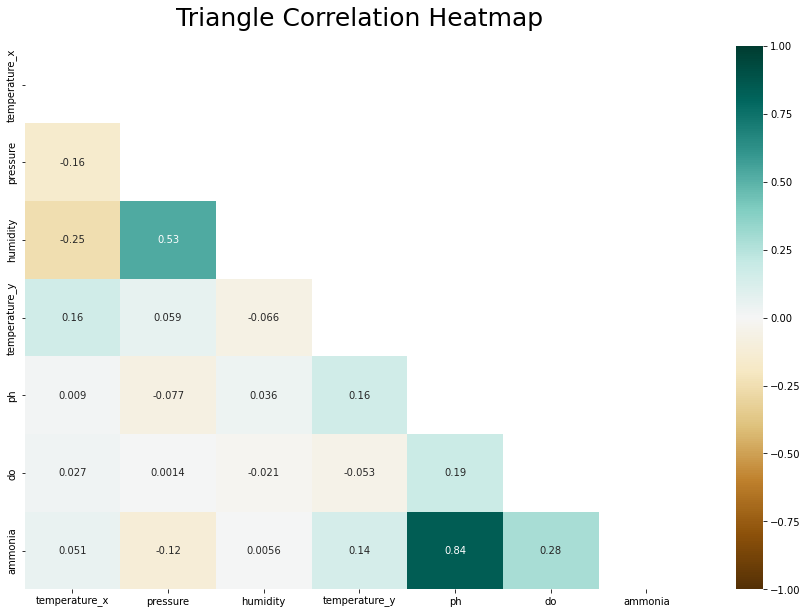

In [685]:
plt.figure(figsize=(15, 10)) 

mask = np.triu(np.ones_like(data.corr(), dtype=np.bool)) 
heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':25}, pad=20);

In [686]:
data = data.drop(columns=['ph'])

In [687]:
df = data.groupby(pd.Grouper(key="timestamp", freq="d")).median()
df = df.rename(columns = {'index':'Description'})
df.reset_index(inplace=True)
data = df[['timestamp', 'temperature_x']]
data.rename(columns = {'timestamp' : 'ds', 'temperature_x': 'y'}, inplace = True)
data

<ipython-input-687-2d477f130755>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
0,2017-03-28,301.372000
1,2017-03-29,301.840000
2,2017-03-30,301.648000
3,2017-03-31,302.188000
4,2017-04-01,302.214000
...,...,...
293,2018-01-15,298.014000
294,2018-01-16,296.914125
295,2018-01-17,296.508250
296,2018-01-18,296.266125


In [688]:
%%time

# wrong = pd.DataFrame({
# 'holiday': 'wrong',
# 'ds': df1.query('y != 31.41333333333333').ds,
# 'lower_window': -1,
# 'upper_window': 1,
# })

m = Prophet(
            growth="linear", 
            daily_seasonality=True, 
            yearly_seasonality = False,
            weekly_seasonality = False,
            seasonality_mode = "multiplicative",
            changepoint_prior_scale = 0.1,
            seasonality_prior_scale = 35
            )

m.add_seasonality(name="monthly",period=30, fourier_order = 3)
m.add_seasonality(name="weekly",
                                period = 7,
                                fourier_order = 40)
# m.add_seasonality(name="yearly", 
#                                 period=365.25,
#                                 fourier_order = 35)
m.add_seasonality(name="quarter",
                                period=365.25 / 4,
                                fourier_order = 5,
                                prior_scale = 5)
m.add_seasonality(name="1/2year",
                                period=365.25 / 2,
                                fourier_order = 5,
                                prior_scale = 5)
# m.add_country_holidays(country_name = 'US')

m.fit(data)
future = m.make_future_dataframe(periods= 7, freq='d',  include_history = False)
forecast1 = m.predict(future)

forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp03daa5pt/t87itljd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp03daa5pt/xs6qt4_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48078', 'data', 'file=/tmp/tmp03daa5pt/t87itljd.json', 'init=/tmp/tmp03daa5pt/xs6qt4_d.json', 'output', 'file=/tmp/tmp03daa5pt/prophet_modelaryvhus9/prophet_model-20230320180614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:06:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:06:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 215 ms, sys: 32.7 ms, total: 248 ms
Wall time: 828 ms


,ds,yhat,yhat_lower,yhat_upper
0,2018-01-20,296.376953,294.837142,297.895244
1,2018-01-21,296.380087,294.845841,297.913484
2,2018-01-22,295.969936,294.471108,297.453631
3,2018-01-23,295.975934,294.529266,297.399744
4,2018-01-24,295.779662,294.355842,297.289023
5,2018-01-25,295.962319,294.511257,297.492909
6,2018-01-26,296.069920,294.668062,297.530995


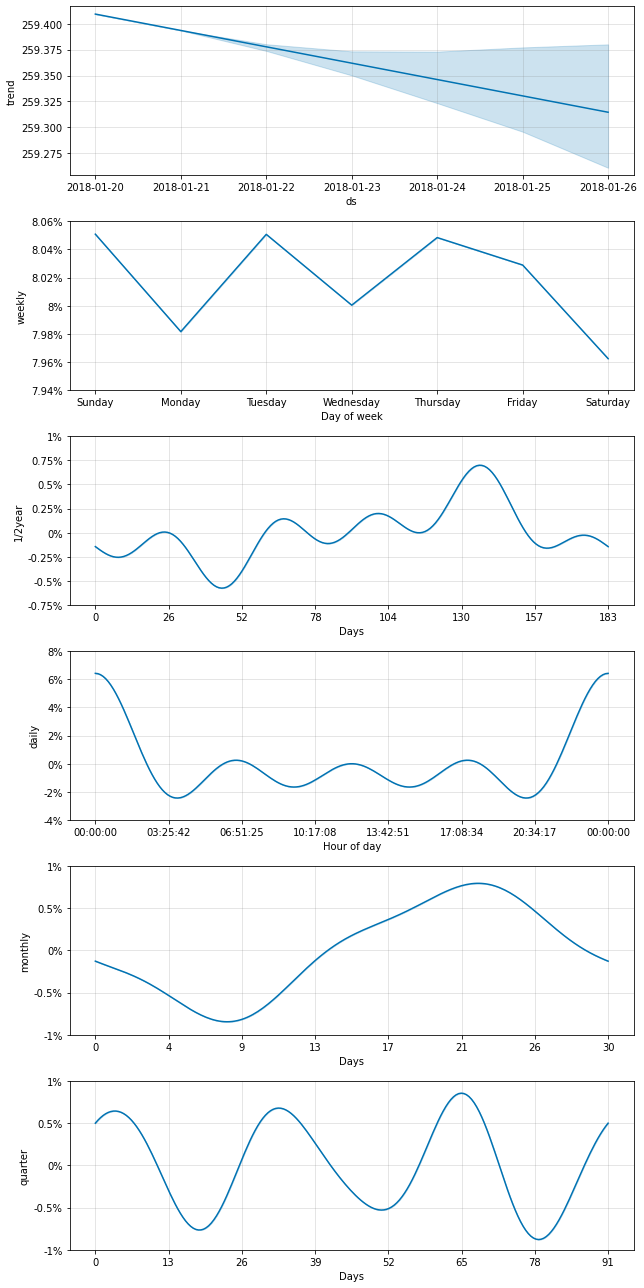

In [689]:
fig2 = m.plot_components(forecast1)

In [690]:
plot_plotly(m, forecast1)

In [691]:
forecastdf = forecast1[['ds', 'yhat']].rename(columns = {'ds':'timestamp', 'yhat': 'temperature_x'})
data = pd.concat([df, forecastdf])
data

,timestamp,temperature_x,pressure,humidity,temperature_y,do,ammonia
0,2017-03-28,301.372000,1026.77000,98.0,27.585000,6.635000,9.014117e-08
1,2017-03-29,301.840000,1025.43000,96.0,34.057500,7.681250,1.262822e-01
2,2017-03-30,301.648000,1013.34375,85.0,32.844667,8.594667,2.162955e-01
3,2017-03-31,302.188000,1026.65000,94.0,31.046667,5.201667,1.656662e-01
4,2017-04-01,302.214000,1025.18000,94.0,31.413333,5.125000,2.799376e-01
...,...,...,...,...,...,...,...
2,2018-01-22,295.969936,NaN,NaN,NaN,NaN,NaN
3,2018-01-23,295.975934,NaN,NaN,NaN,NaN,NaN
4,2018-01-24,295.779662,NaN,NaN,NaN,NaN,NaN
5,2018-01-25,295.962319,NaN,NaN,NaN,NaN,NaN


In [692]:
data = data.groupby(pd.Grouper(key="timestamp", freq="d")).mean()
data = data.rename(columns = {'index':'timestamp'})
data

,temperature_x,pressure,humidity,temperature_y,do,ammonia
timestamp,,,,,,
2017-03-28,301.372000,1026.77000,98.0,27.585000,6.635000,9.014117e-08
2017-03-29,301.840000,1025.43000,96.0,34.057500,7.681250,1.262822e-01
2017-03-30,301.648000,1013.34375,85.0,32.844667,8.594667,2.162955e-01
2017-03-31,302.188000,1026.65000,94.0,31.046667,5.201667,1.656662e-01
2017-04-01,302.214000,1025.18000,94.0,31.413333,5.125000,2.799376e-01
...,...,...,...,...,...,...
2018-01-22,295.969936,NaN,NaN,NaN,NaN,NaN
2018-01-23,295.975934,NaN,NaN,NaN,NaN,NaN
2018-01-24,295.779662,NaN,NaN,NaN,NaN,NaN


In [693]:
for i in trange(1, len(df.columns)):
    if df.columns[i] != 'temperature_x':
        print(df.columns[i])

  0%|          | 0/6 [00:00<?, ?it/s]

pressure
humidity
temperature_y
do
ammonia


In [719]:
data1 = data[:-7]

In [721]:
def make_features(data, max_lag, rolling_mean_size):
     # four new calendar attributes: year, month, day and day of the week
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    # lagging values. max_lag, which will set the maximum lag size.
    for lag in range(1, max_lag + 1):
        for i in trange(1, len(df.columns)):
            if df.columns[i] != 'temperature_x':
                data['lag_{}_{}'.format(lag, df.columns[i])] = data[df.columns[i]].shift(lag)
                print(df.columns[i])

    # moving average
    # data['rolling_mean'] = data['x1'].shift().rolling(rolling_mean_size).mean()

make_features(data1, 7, 5)
data1

<ipython-input-721-41caac5ba55a>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41caac5ba55a>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41caac5ba55a>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41c

  0%|          | 0/6 [00:00<?, ?it/s]

pressure
humidity
temperature_y
do
ammonia


<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-

  0%|          | 0/6 [00:00<?, ?it/s]

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-

pressure
humidity
temperature_y
do
ammonia


  0%|          | 0/6 [00:00<?, ?it/s]

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-

pressure
humidity
temperature_y
do
ammonia


  0%|          | 0/6 [00:00<?, ?it/s]

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-

pressure
humidity
temperature_y
do
ammonia


  0%|          | 0/6 [00:00<?, ?it/s]

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-

pressure
humidity
temperature_y
do
ammonia


  0%|          | 0/6 [00:00<?, ?it/s]

pressure
humidity
temperature_y
do
ammonia


<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-

  0%|          | 0/6 [00:00<?, ?it/s]

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-41caac5ba55a>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-721-

pressure
humidity
temperature_y
do
ammonia


,temperature_x,pressure,humidity,temperature_y,do,ammonia,year,month,day,dayofweek,...,lag_6_pressure,lag_6_humidity,lag_6_temperature_y,lag_6_do,lag_6_ammonia,lag_7_pressure,lag_7_humidity,lag_7_temperature_y,lag_7_do,lag_7_ammonia
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-03-28,301.372000,1026.77000,98.000,27.585000,6.635000,9.014117e-08,2017,3,28,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-29,301.840000,1025.43000,96.000,34.057500,7.681250,1.262822e-01,2017,3,29,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-30,301.648000,1013.34375,85.000,32.844667,8.594667,2.162955e-01,2017,3,30,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-31,302.188000,1026.65000,94.000,31.046667,5.201667,1.656662e-01,2017,3,31,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-01,302.214000,1025.18000,94.000,31.413333,5.125000,2.799376e-01,2017,4,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-15,298.014000,1014.46000,72.750,31.413333,5.125000,2.799376e-01,2018,1,15,0,...,1016.86875,64.875,31.413333,5.125,0.279938,1014.38000,72.625,31.413333,5.125,0.279938
2018-01-16,296.914125,1014.42875,77.250,31.413333,5.125000,2.799376e-01,2018,1,16,1,...,1016.82875,70.250,31.413333,5.125,0.279938,1016.86875,64.875,31.413333,5.125,0.279938
2018-01-17,296.508250,1014.15750,71.625,31.413333,5.125000,2.799376e-01,2018,1,17,2,...,1015.71625,71.625,31.413333,5.125,0.279938,1016.82875,70.250,31.413333,5.125,0.279938


In [722]:
data1 = data1.drop(columns=['pressure', 'humidity' ,'temperature_y' ,'do', 'ammonia'])

In [723]:
data_split = data1[:-7]
test = data1[-7:]
train, valid = np.split(data1.sample(frac=1, random_state=12345),
                                 [int(.85*len(data1))])

train = train.dropna()
valid = valid.dropna()
test = test.dropna()
# variables for features and target feature
features_train = train.drop(['temperature_x'], axis=1)
target_train = train['temperature_x']

features_valid = valid.drop(['temperature_x'], axis=1)
target_valid = valid['temperature_x']

features_test = test.drop(['temperature_x'], axis=1)
target_test = test['temperature_x']
print(train.shape)
print(valid.shape)
print(test.shape)

(247, 40)
(44, 40)
(7, 40)


In [724]:
features_test

,year,month,day,dayofweek,lag_1_pressure,lag_1_humidity,lag_1_temperature_y,lag_1_do,lag_1_ammonia,lag_2_pressure,...,lag_6_pressure,lag_6_humidity,lag_6_temperature_y,lag_6_do,lag_6_ammonia,lag_7_pressure,lag_7_humidity,lag_7_temperature_y,lag_7_do,lag_7_ammonia
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-13,2018,1,13,5,1014.85375,75.250,31.413333,5.125,0.279938,1015.71625,...,1013.72250,68.250,31.413333,5.125,0.279938,1012.71250,66.125,31.413333,5.125,0.279938
2018-01-14,2018,1,14,6,1014.38875,78.000,31.413333,5.125,0.279938,1014.85375,...,1014.38000,72.625,31.413333,5.125,0.279938,1013.72250,68.250,31.413333,5.125,0.279938
2018-01-15,2018,1,15,0,1015.11875,76.375,31.413333,5.125,0.279938,1014.38875,...,1016.86875,64.875,31.413333,5.125,0.279938,1014.38000,72.625,31.413333,5.125,0.279938
2018-01-16,2018,1,16,1,1014.46000,72.750,31.413333,5.125,0.279938,1015.11875,...,1016.82875,70.250,31.413333,5.125,0.279938,1016.86875,64.875,31.413333,5.125,0.279938
2018-01-17,2018,1,17,2,1014.42875,77.250,31.413333,5.125,0.279938,1014.46000,...,1015.71625,71.625,31.413333,5.125,0.279938,1016.82875,70.250,31.413333,5.125,0.279938
2018-01-18,2018,1,18,3,1014.15750,71.625,31.413333,5.125,0.279938,1014.42875,...,1014.85375,75.250,31.413333,5.125,0.279938,1015.71625,71.625,31.413333,5.125,0.279938
2018-01-19,2018,1,19,4,1014.50625,73.875,26.370000,1.440,0.000507,1014.15750,...,1014.38875,78.000,31.413333,5.125,0.279938,1014.85375,75.250,31.413333,5.125,0.279938


In [725]:
%%time

model = LinearRegression()
model = model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
mse = mean_squared_error(target_valid, predictions_valid)
print("MSE:", mse)
rmse = mse ** 0.5 
print("RMSE:", rmse)

MSE: 2.7498424911058663
RMSE: 1.658264903779208
CPU times: user 14.7 ms, sys: 0 ns, total: 14.7 ms
Wall time: 17.4 ms


Text(0, 0.5, 'values')

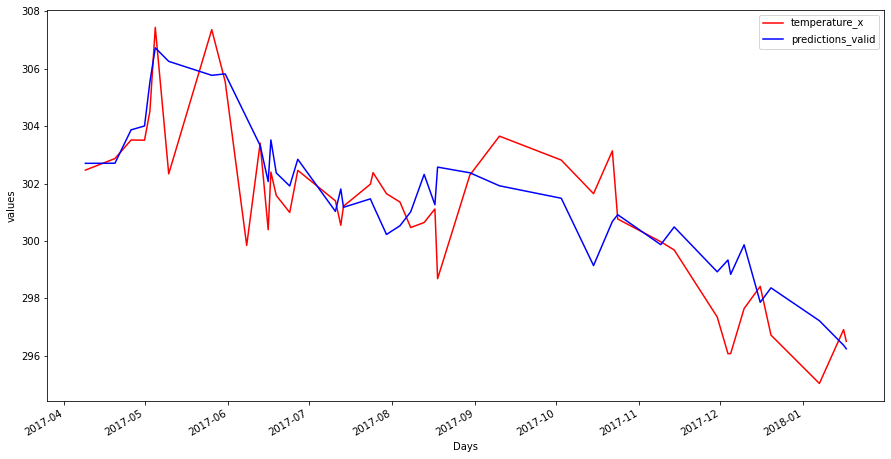

In [726]:
targetv1= pd.DataFrame(target_valid)
targetv1['predictions_valid'] = predictions_valid

targetv1.plot( color=['red', 'blue'], figsize=(15,8))
# Add Title and Labels
plt.title('')
plt.xlabel('Days')
plt.ylabel('values')

In [727]:
%%time
model1 = CatBoostRegressor(iterations=100, learning_rate=0.5, depth = 8)
# Fit model
model1.fit(features_train, target_train, verbose=10) 
predictions_valid1 = model1.predict(features_valid)
mse1 = mean_squared_error(target_valid, predictions_valid1)
print("MSE:", mse1)
rmse1 = mse1 ** 0.5 
print("RMSE:", rmse1)

0:	learn: 2.2405081	total: 14.9ms	remaining: 1.47s
10:	learn: 0.9186238	total: 136ms	remaining: 1.1s
20:	learn: 0.5430965	total: 255ms	remaining: 960ms
30:	learn: 0.3093850	total: 372ms	remaining: 827ms
40:	learn: 0.1740576	total: 483ms	remaining: 695ms
50:	learn: 0.0975973	total: 616ms	remaining: 591ms
60:	learn: 0.0664704	total: 725ms	remaining: 463ms
70:	learn: 0.0454003	total: 820ms	remaining: 335ms
80:	learn: 0.0321217	total: 934ms	remaining: 219ms
90:	learn: 0.0217593	total: 1.03s	remaining: 102ms
99:	learn: 0.0145964	total: 1.14s	remaining: 0us
MSE: 2.302530115292558
RMSE: 1.5174090138431886
CPU times: user 2.11 s, sys: 44.7 ms, total: 2.16 s
Wall time: 1.21 s


Text(0, 0.5, 'values')

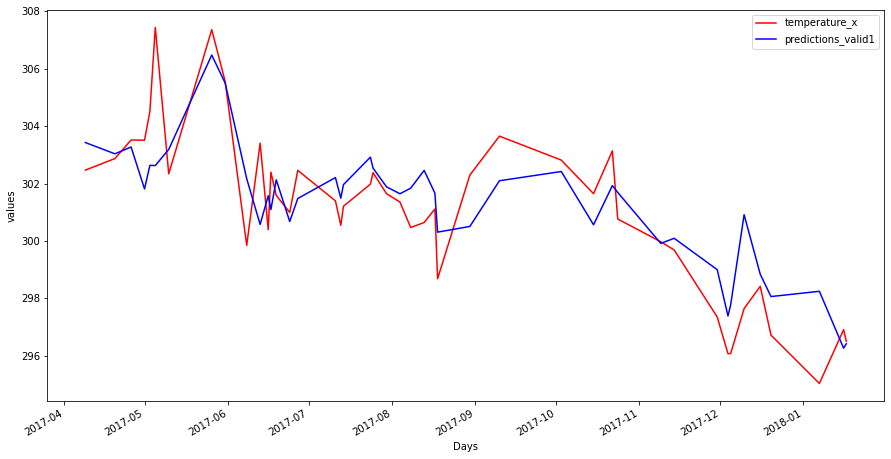

In [728]:
targetv2= pd.DataFrame(target_valid)
targetv2['predictions_valid1'] = predictions_valid1

targetv2.plot( color=['red', 'blue'], figsize=(15,8))
# Add Title and Labels
plt.title('')
plt.xlabel('Days')
plt.ylabel('values')

In [729]:
%%time
model4 = RandomForestRegressor(n_estimators=100, max_depth = 13)
model4.fit(features_train, target_train) 
predictions_valid4 = model4.predict(features_valid)
mse4 = mean_squared_error(target_valid, predictions_valid4)
print("MSE:", mse4)
rmse4 = mse4 ** 0.5 
print("RMSE:", rmse4)

MSE: 1.855070581461373
RMSE: 1.3620097582107746
CPU times: user 442 ms, sys: 2.46 ms, total: 445 ms
Wall time: 446 ms


Text(0, 0.5, 'values')

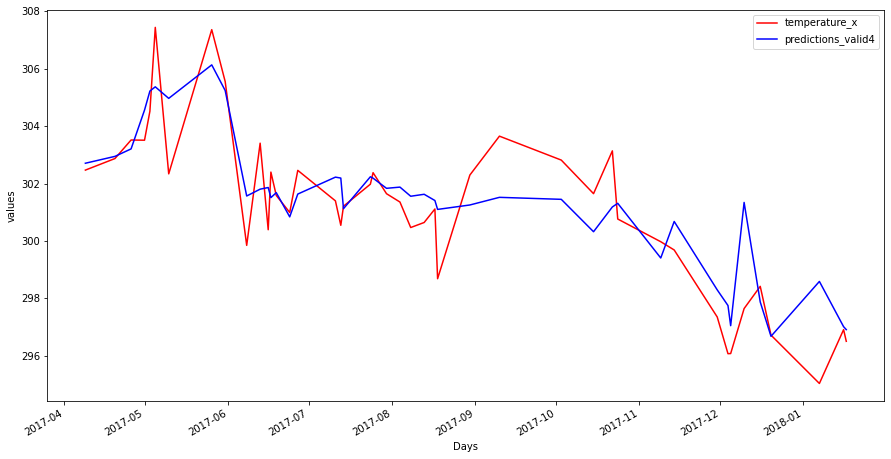

In [730]:
targetv= pd.DataFrame(target_valid)
targetv['predictions_valid4'] = predictions_valid4

targetv.plot( color=['red', 'blue'], figsize=(15,8))
# Add Title and Labels
plt.title('')
plt.xlabel('Days')
plt.ylabel('values')

In [731]:
%%time
predictions_test = model1.predict(features_test)
mse1 = mean_squared_error(target_test, predictions_test)
print("MSE:", mse1)
rmse1 = mse1 ** 0.5 
print("RMSE:", rmse1)

MSE: 0.060502492944814246
RMSE: 0.24597254510374578
CPU times: user 9.85 ms, sys: 4.05 ms, total: 13.9 ms
Wall time: 17.4 ms


Text(0, 0.5, 'values')

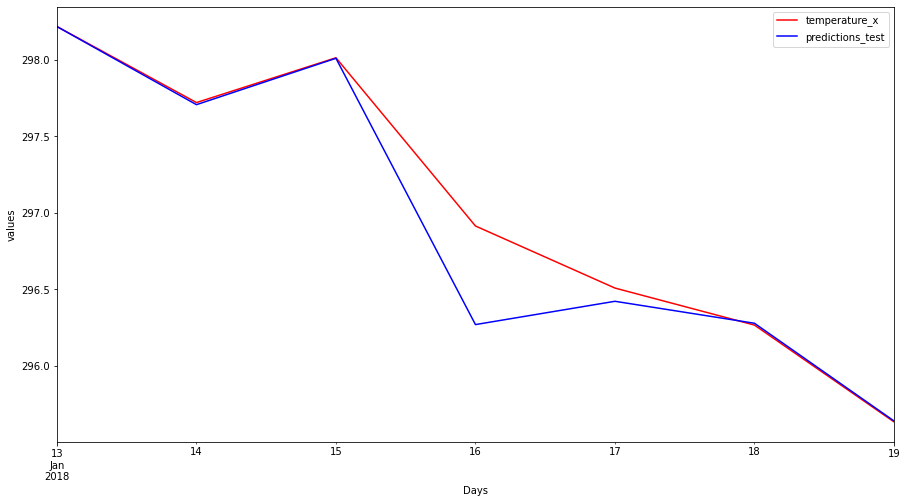

In [732]:
fin= pd.DataFrame(target_test)
fin['predictions_test'] = predictions_test

fin.plot( color=['red', 'blue'], figsize=(15,8))
# Add Title and Labels
plt.title('')
plt.xlabel('Days')
plt.ylabel('values')

In [733]:
fin


,temperature_x,predictions_test
timestamp,,
2018-01-13,298.218625,298.217911
2018-01-14,297.721125,297.707405
2018-01-15,298.014000,298.010697
2018-01-16,296.914125,296.269418
2018-01-17,296.508250,296.421707
2018-01-18,296.266125,296.278139
2018-01-19,295.633500,295.639584


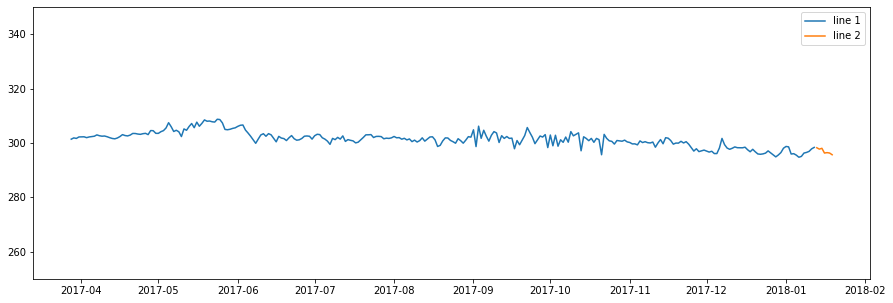

In [734]:
plt.figure(figsize=(15, 5))
plt.ylim([250, 350])
plt.plot(data_split.index, data_split.temperature_x, label = "line 1")
plt.plot(fin.index, fin.predictions_test, label= "line 2")
plt.legend()
plt.show()